In [1]:
!conda activate DS807

## Preparation of data

### Labeling Data and converting images to array values

In [2]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray

In [3]:
##############
# Func for creating 1D image arrays

def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


In [4]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data ():
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1')

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [5]:
#load data and shuffle them around
df = load_img_data()
#df = df.sample(frac=1).reset_index(drop=True)
df

index string CC  D  Y  \
0          1   1836  0  3  6   
1          2   1836  0  3  6   
2          3   1840  0  4  0   
3          4   1840  0  4  0   
4          5   1823  0  2  3   
...      ...    ... .. .. ..   
11995  11996   1808  0  0  8   
11996  11997   1809  0  0  9   
11997  11998   1840  0  4  0   
11998  11999   1840  0  4  0   
11999  12000   1810  0  1  0   

                                               img_value   filename  
0      [[[166.0], [167.0], [166.0], [162.0], [164.0],...      1.jpg  
1      [[[169.0], [168.0], [169.0], [170.0], [166.0],...      2.jpg  
2      [[[167.0], [169.0], [169.0], [166.0], [165.0],...      3.jpg  
3      [[[167.0], [165.0], [165.0], [165.0], [163.0],...      4.jpg  
4      [[[62.0], [45.0], [45.0], [37.0], [40.0], [33....      5.jpg  
...                                                  ...        ...  
11995  [[[88.0], [62.0], [60.0], [68.0], [61.0], [101...  11996.jpg  
11996  [[[173.0], [171.0], [173.0], [175.0], [174.0],...  11997.jpg  
11997  [[[189.0], [189.0], [189.0], [189.0], [189.0],...  11998.jpg  
11998  [[[191.0], [192.0], [192.0], [192.0], [193.0],...  11999.jpg  
11999  [[[175.0], [177.0], [177.0], [175.0], [174.0],...  12000.jpg  

[12000 rows x 7 columns]

### Defining fixed train, test and valdiation sets.

In [6]:
df = df.drop(columns=['index','string','filename'])

### Split train, val, test

#### Subsetting df

In [7]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

#### Creating labels

In [8]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


#### Creating image values

In [9]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


## Question 2.2.B, Optimizations, hyperparameter search

Importing packages:

In [10]:
import tensorflow as tf
import data_loader as dl
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt


Defining a function for plotting model history:

In [11]:
def plots (history_new, label, history_old):
    fig = plt.figure(figsize=plt.figaspect(0.3))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history_new.history['loss'], label='Training loss')
    ax.plot(history_new.history['val_loss'], label='Val loss')
    ax.plot(history_old.history['loss'], 'purple', label = 'Training loss (no optim.)')
    ax.plot(history_old.history['val_loss'], 'red', label = 'Val loss (no optim.)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss, '+label)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history_new.history['accuracy'], label='Training accuracy')
    ax.plot(history_new.history['val_accuracy'], label='Val accuracy')
    ax.plot(history_old.history['accuracy'], 'purple', label = 'Training acc (no optim.)')
    ax.plot(history_old.history['val_accuracy'], 'red', label = 'Val acc (no optim.)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy, '+label)

    plt.show()

### **Model CC**

#### Previous model VGG4

In [13]:
modelCC = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

modelCC.compile(
    optimizer='adam',
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 
historyCCvgg4 = modelCC.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)

In [21]:
historyCCvgg4.history['val_accuracy'][-1]

0.9854166507720947

In [22]:
historyCCvgg4.history['val_loss'][-1]

0.1500152200460434

#### Batch normalization

##### **-2 first layers**

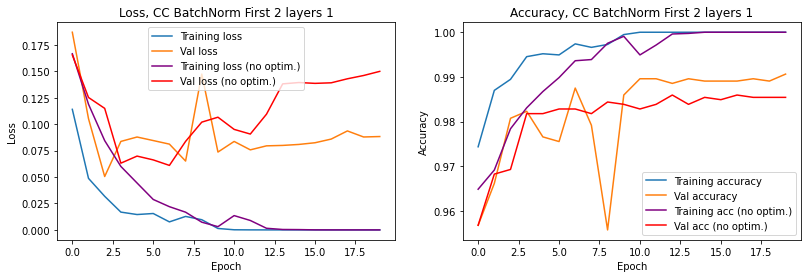

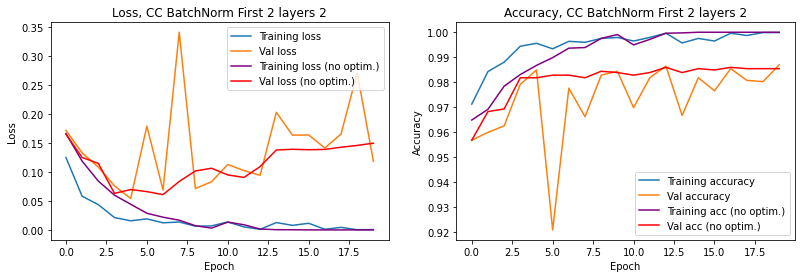

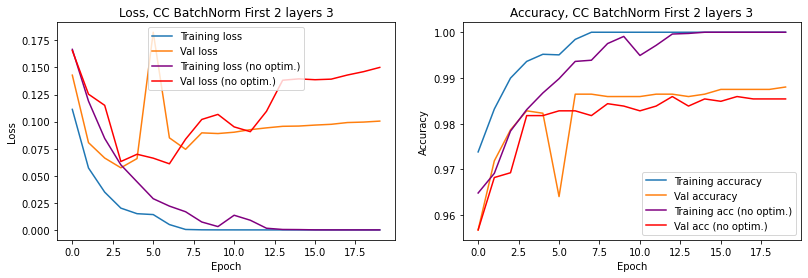

In [28]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCbatchFIRST1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchFIRST1,'CC BatchNorm First 2 layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCbatchFIRST2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchFIRST2,'CC BatchNorm First 2 layers '+str(i), historyCCvgg4)   
    else:
        historyCCbatchFIRST3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchFIRST3,'CC BatchNorm First 2 layers '+str(i), historyCCvgg4)
        
    i += 1

In [31]:
historyCCbatchFIRST1.history['val_accuracy'][-1]

0.9906250238418579

In [32]:
historyCCbatchFIRST1.history['val_loss'][-1]

0.0883462131023407

##### **-2 last layers**

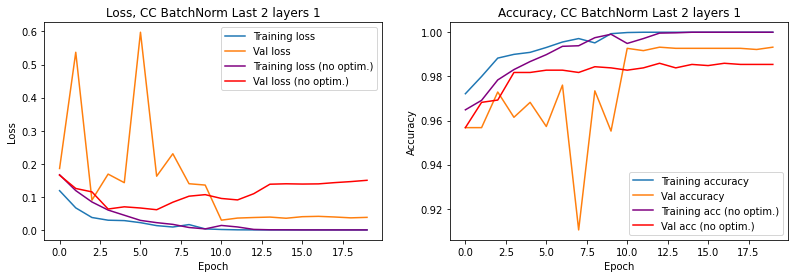

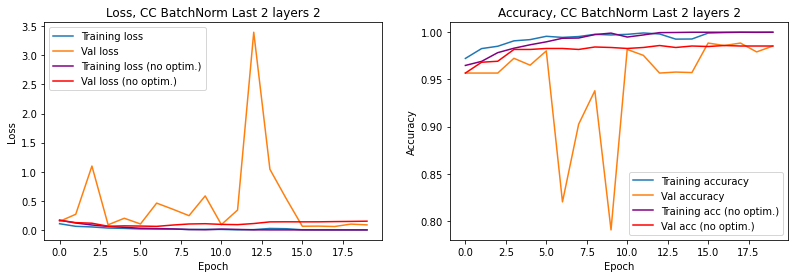

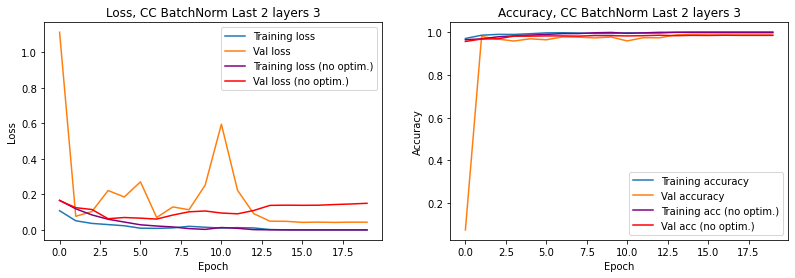

In [65]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCbatchLAST1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchLAST1,'CC BatchNorm Last 2 layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCbatchLAST2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchLAST2,'CC BatchNorm Last 2 layers '+str(i), historyCCvgg4)   
    else:
        historyCCbatchLAST3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchLAST3,'CC BatchNorm Last 2 layers '+str(i), historyCCvgg4)
        
    i += 1

In [68]:
historyCCbatchLAST3.history['val_accuracy'][-1]

0.9921875

In [69]:
historyCCbatchLAST3.history['val_loss'][-1]

0.0436091423034668

##### **-all 4 layers**

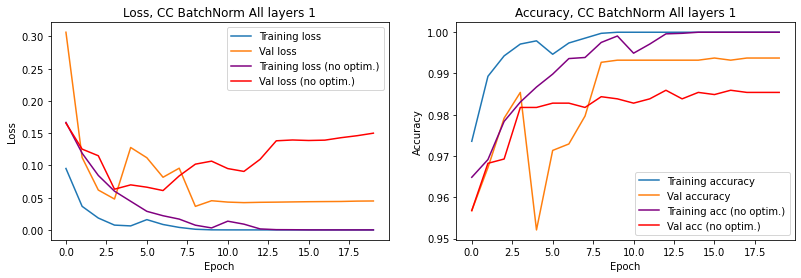

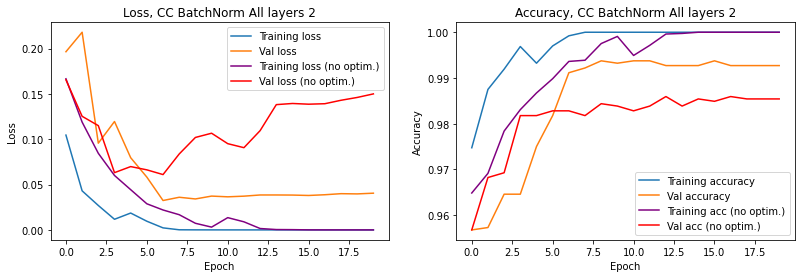

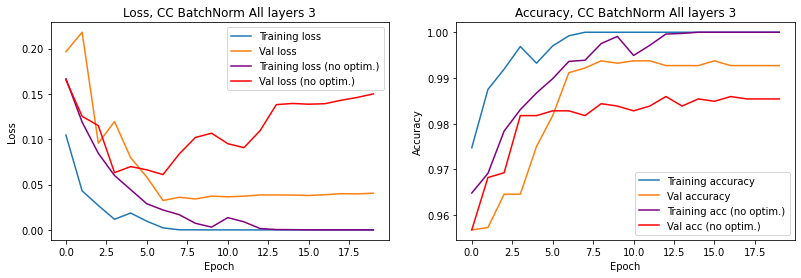

In [24]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 
    
    if i == 1:
        historyCCbatchALL1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchALL1,'CC BatchNorm All layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCbatchALL2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchALL2,'CC BatchNorm All layers '+str(i), historyCCvgg4)   
    else:
        historyCCbatchALL3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchALL3,'CC BatchNorm All layers '+str(i), historyCCvgg4)
        
    i += 1

In [25]:
historyCCbatchALL1.history['val_accuracy'][-1]

0.9937499761581421

In [26]:
historyCCbatchALL1.history['val_loss'][-1]

0.044871736317873

#### Learning rates

##### **0.001**

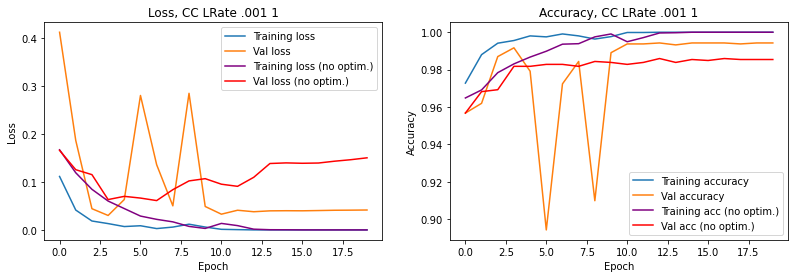

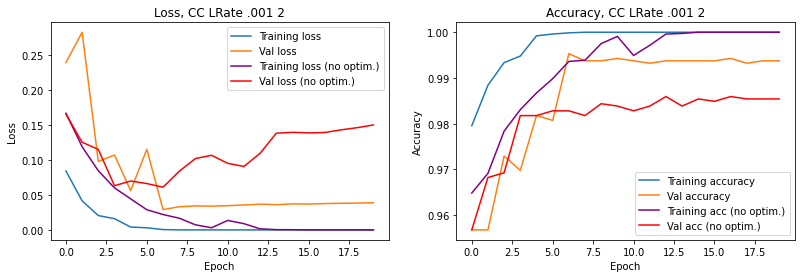

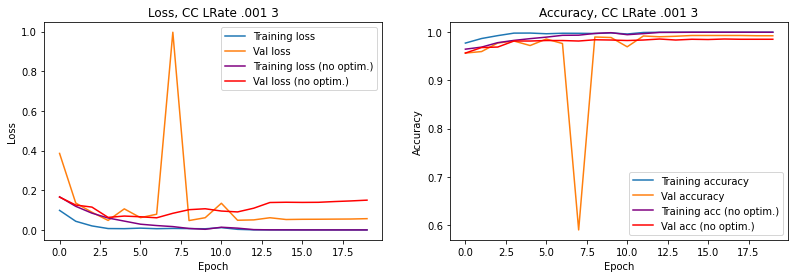

In [70]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCClearning1_1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning1_1,'CC LRate .001 '+str(i), historyCCvgg4)
    elif i ==2:
        historyCClearning1_2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning1_2,'CC LRate .001 '+str(i), historyCCvgg4)   
    else:
        historyCClearning1_3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning1_3,'CC LRate .001 '+str(i), historyCCvgg4)
        
    i += 1

In [82]:
historyCClearning1_1.history['val_accuracy'][-1]

0.9942708611488342

In [83]:
historyCClearning1_1.history['val_loss'][-1]

0.041429031640291214

##### **0.0008**

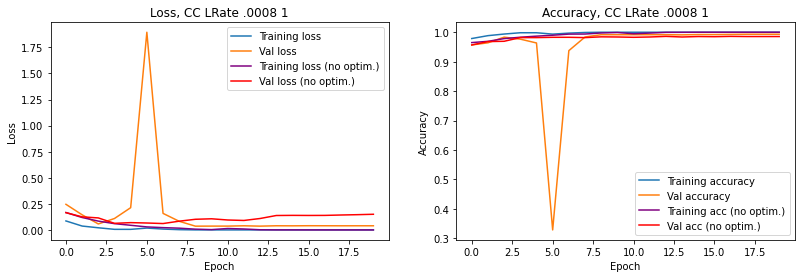

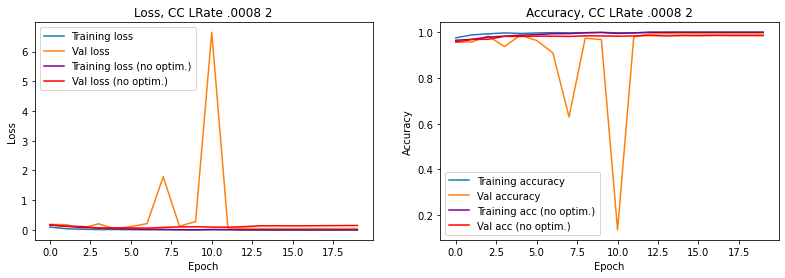

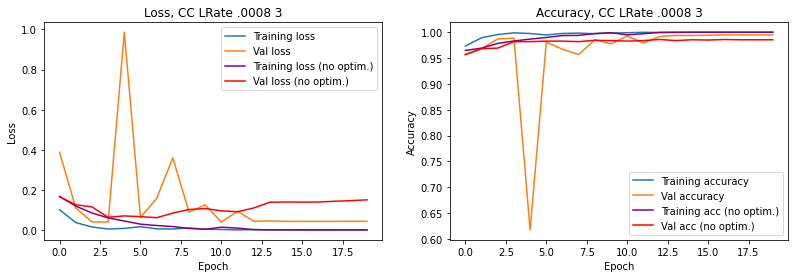

In [71]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCClearning08_1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning08_1,'CC LRate .0008 '+str(i), historyCCvgg4)
    elif i ==2:
        historyCClearning08_2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning08_2,'CC LRate .0008 '+str(i), historyCCvgg4)   
    else:
        historyCClearning08_3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning08_3,'CC LRate .0008 '+str(i), historyCCvgg4)
        
    i += 1

In [86]:
historyCClearning08_3.history['val_accuracy'][-1]

0.9947916865348816

In [87]:
historyCClearning08_3.history['val_loss'][-1]

0.04318391531705856

##### **0.0005**

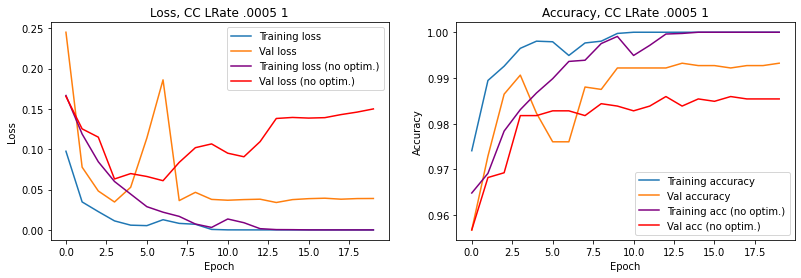

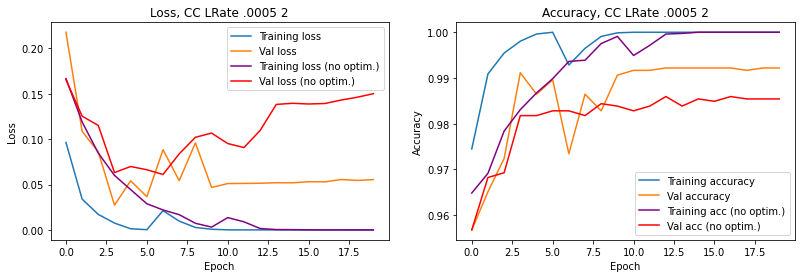

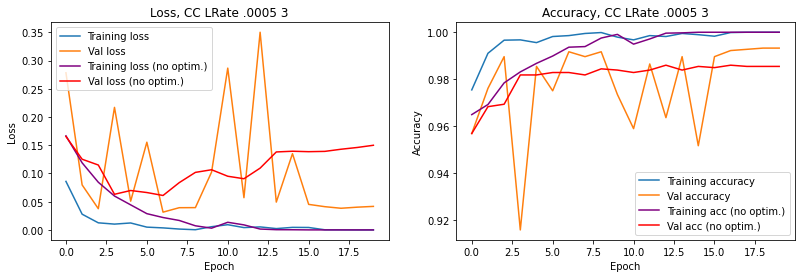

In [72]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCClearning05_1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning05_1,'CC LRate .0005 '+str(i), historyCCvgg4)
    elif i ==2:
        historyCClearning05_2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning05_2,'CC LRate .0005 '+str(i), historyCCvgg4)   
    else:
        historyCClearning05_3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning05_3,'CC LRate .0005 '+str(i), historyCCvgg4)
        
    i += 1

In [93]:
historyCClearning05_1.history['val_accuracy'][-1]

0.9932291507720947

In [94]:
historyCClearning05_1.history['val_loss'][-1]

0.03897080942988396

#### Dropout 0.5

##### **First 2 layers**

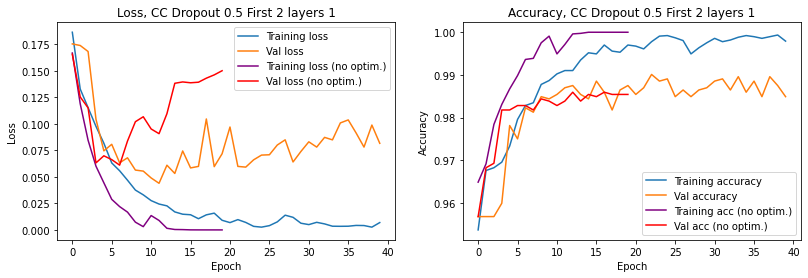

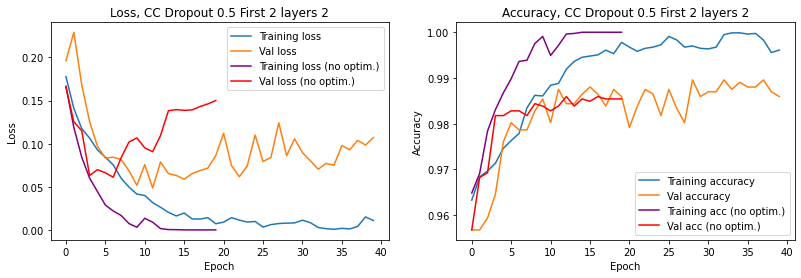

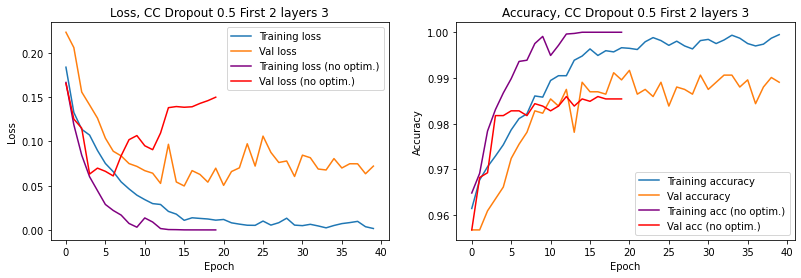

In [131]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCdropFIRST1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropFIRST1,'CC Dropout 0.5 First 2 layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCdropFIRST2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropFIRST2,'CC Dropout 0.5 First 2 layers '+str(i), historyCCvgg4)   
    else:
        historyCCdropFIRST3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropFIRST3,'CC Dropout 0.5 First 2 layers '+str(i), historyCCvgg4)
        
    i += 1

In [140]:
historyCCdropFIRST3.history['val_accuracy'][-1]

0.989062488079071

In [141]:
historyCCdropFIRST3.history['val_loss'][-1]

0.07213462889194489

##### **Last 2 layers**

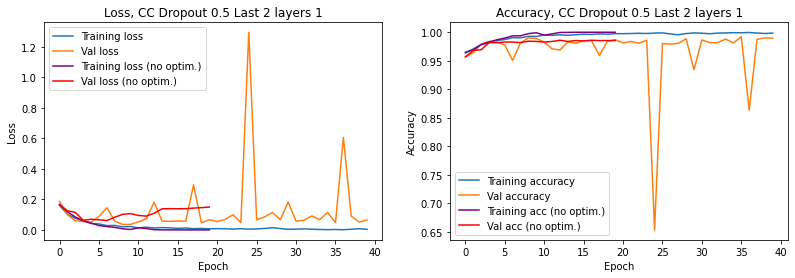

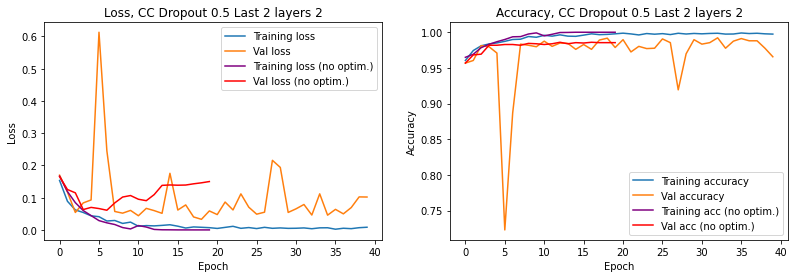

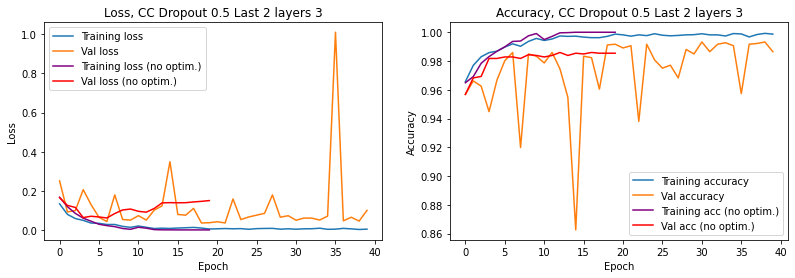

In [132]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCdropLAST1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropLAST1,'CC Dropout 0.5 Last 2 layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCdropLAST2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropLAST2,'CC Dropout 0.5 Last 2 layers '+str(i), historyCCvgg4)   
    else:
        historyCCdropLAST3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropLAST3,'CC Dropout 0.5 Last 2 layers '+str(i), historyCCvgg4)
        
    i += 1

In [145]:
historyCCdropLAST1.history['val_accuracy'][-1]

0.9895833134651184

In [146]:
historyCCdropLAST1.history['val_loss'][-1]

0.06463824957609177

##### **All layers**

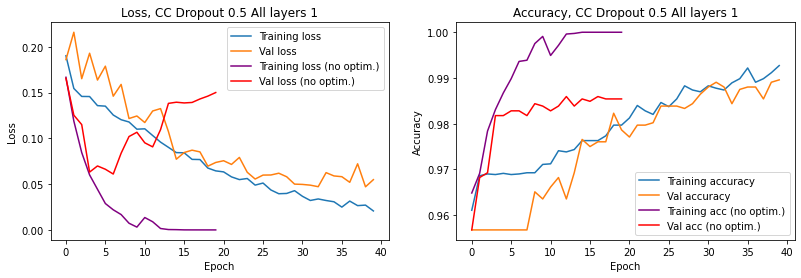

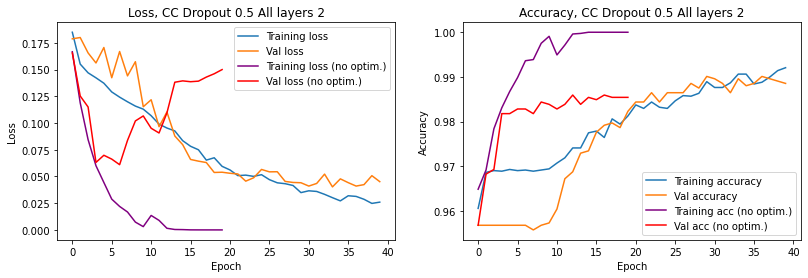

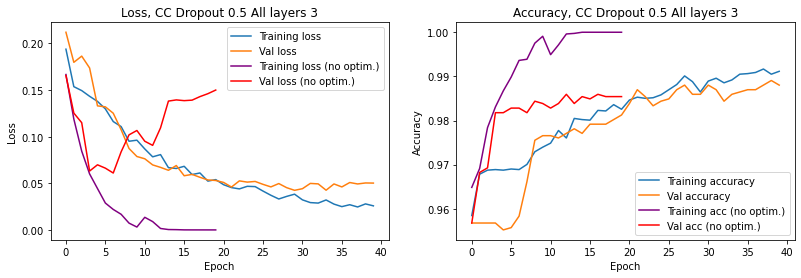

In [133]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCdropALL1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropALL1,'CC Dropout 0.5 All layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCdropALL2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropALL2,'CC Dropout 0.5 All layers '+str(i), historyCCvgg4)   
    else:
        historyCCdropALL3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropALL3,'CC Dropout 0.5 All layers '+str(i), historyCCvgg4)
        
    i += 1

In [150]:
historyCCdropALL1.history['val_accuracy'][-1]

0.9895833134651184

In [151]:
historyCCdropALL1.history['val_loss'][-1]

0.05489330738782883

#### Earlystopping on optimized model

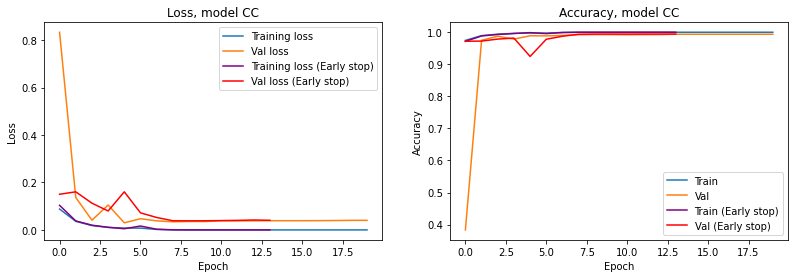

In [69]:
 ### with early stop
model = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
loss= 'binary_crossentropy',
metrics=['accuracy'],
) 

history_stop = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

  
#### Without early stop

model = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 

history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)

########
### Plot with and without early stop
########

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
ax.plot(history_stop.history['loss'], 'purple', label = 'Training loss (Early stop)')
ax.plot(history_stop.history['val_loss'], 'red', label = 'Val loss (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
ax.plot(history_stop.history['accuracy'], 'purple', label = 'Train (Early stop)')
ax.plot(history_stop.history['val_accuracy'], 'red', label = 'Val (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, model CC')

plt.show()

#### Performance on test data

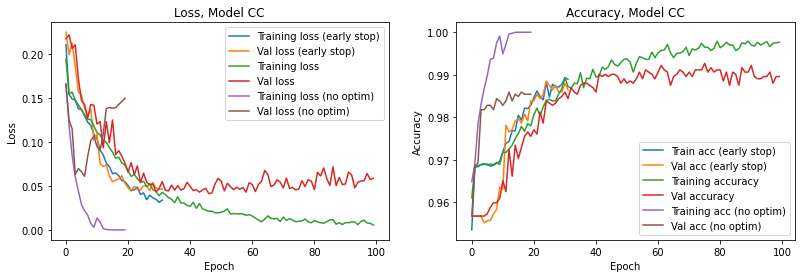

In [192]:
 ### with early stop
model_stop = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_stop.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
loss= 'binary_crossentropy',
metrics=['accuracy'],
) 

history_stop = model_stop.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

 ### withOUT early stop
model_nostop = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_nostop.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
loss= 'binary_crossentropy',
metrics=['accuracy'],
) 

history_no_stop = model_nostop.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=100, verbose=0)

##############################################################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_stop.history['loss'], label='Training loss (early stop)')
ax.plot(history_stop.history['val_loss'], label = 'Val loss (early stop)')
ax.plot(history_no_stop.history['loss'], label='Training loss')
ax.plot(history_no_stop.history['val_loss'], label = 'Val loss')
ax.plot(historyCCvgg4.history['loss'], label='Training loss (no optim)')
ax.plot(historyCCvgg4.history['val_loss'], label = 'Val loss (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_stop.history['accuracy'], label='Train acc (early stop)')
ax.plot(history_stop.history['val_accuracy'], label = 'Val acc (early stop)')
ax.plot(history_no_stop.history['accuracy'], label='Training accuracy')
ax.plot(history_no_stop.history['val_accuracy'],  label = 'Val accuracy')
ax.plot(historyCCvgg4.history['accuracy'], label='Training acc (no optim)')
ax.plot(historyCCvgg4.history['val_accuracy'], label = 'Val acc (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model CC')

plt.show()


In [193]:
history_stop.history['val_accuracy'][-1]

0.9864583611488342

In [209]:
history_stop.history['val_loss'][-1]

0.04660053551197052

In [194]:
history_no_stop.history['val_accuracy'][-1]

0.9895833134651184

In [195]:
historyCCvgg4.history['val_accuracy'][-1]

0.9854166507720947

In [240]:
model_stop.save('models/model_CC_optimized_earlystop.h5')

### **ModelY**

#### Previous model VGG4

In [13]:
modelY = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

modelY.compile(
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

historyYvgg4 = modelY.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)

In [14]:
historyYvgg4.history['val_accuracy'][-1]

0.8114583492279053

In [15]:
historyYvgg4.history['val_loss'][-1]

1.62437903881073

#### Batch normalization

##### **-2 first layers**

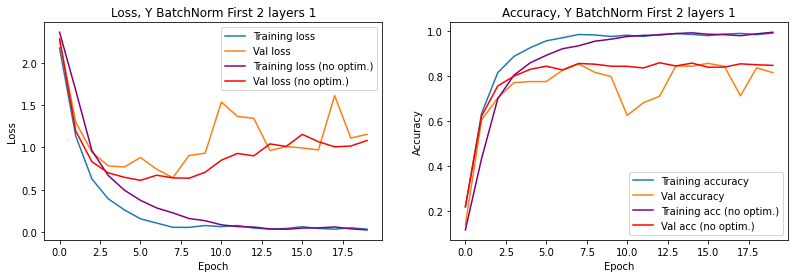

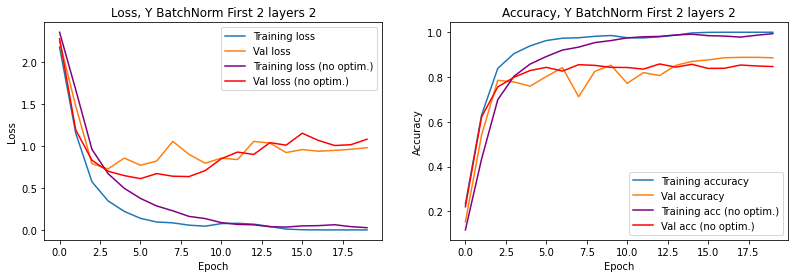

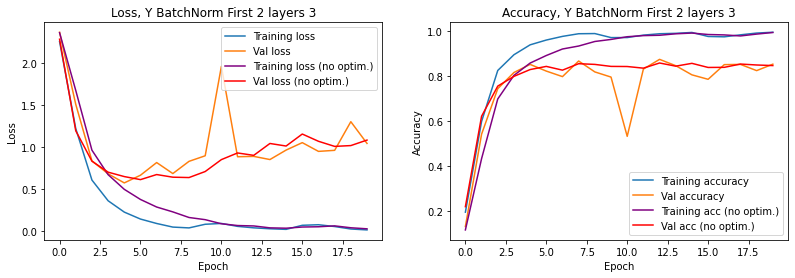

In [41]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYbatchFIRST1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchFIRST1,'Y BatchNorm First 2 layers '+str(i), historyYvgg4)
    elif i ==2:
        historyYbatchFIRST2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchFIRST2,'Y BatchNorm First 2 layers '+str(i), historyYvgg4)   
    else:
        historyYbatchFIRST3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchFIRST3,'Y BatchNorm First 2 layers '+str(i), historyYvgg4)
        
    i += 1

In [46]:
historyYbatchFIRST2.history['val_accuracy'][-1]

0.885937511920929

In [47]:
historyYbatchFIRST2.history['val_loss'][-1]

0.9817343950271606

##### **-2 last layers**

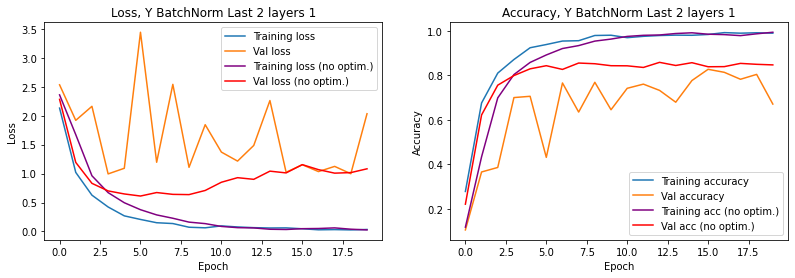

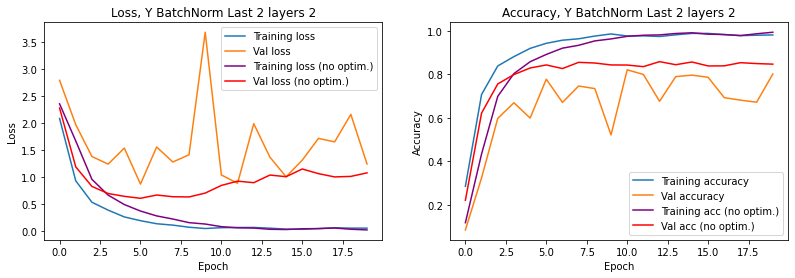

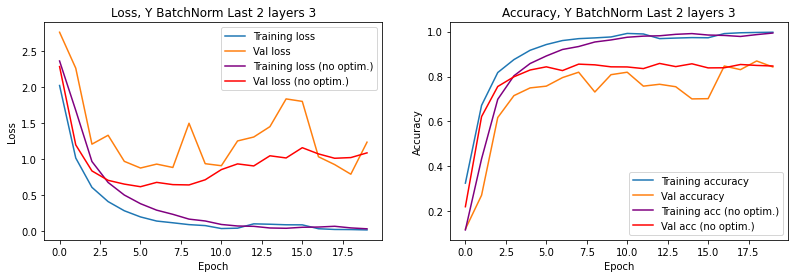

In [39]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYbatchLAST1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchLAST1,'Y BatchNorm Last 2 layers '+str(i), historyYvgg4)
    elif i ==2:
        historyYbatchLAST2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchLAST2,'Y BatchNorm Last 2 layers '+str(i), historyYvgg4)   
    else:
        historyYbatchLAST3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchLAST3,'Y BatchNorm Last 2 layers '+str(i), historyYvgg4)
        
    i += 1

In [42]:
historyYbatchLAST3.history['val_accuracy'][-1]

0.8427083492279053

In [43]:
historyYbatchLAST3.history['val_loss'][-1]

1.2308852672576904

##### **-all 4 layers**

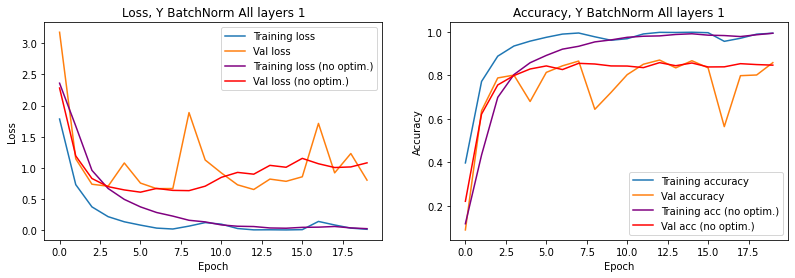

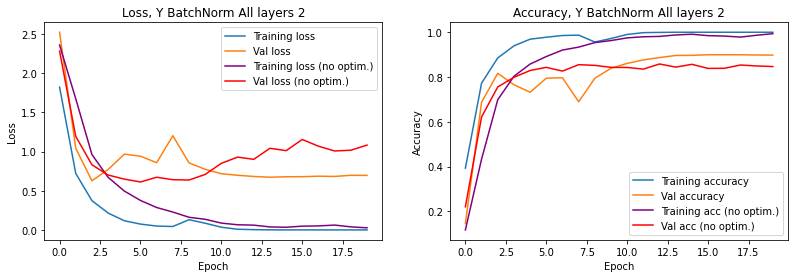

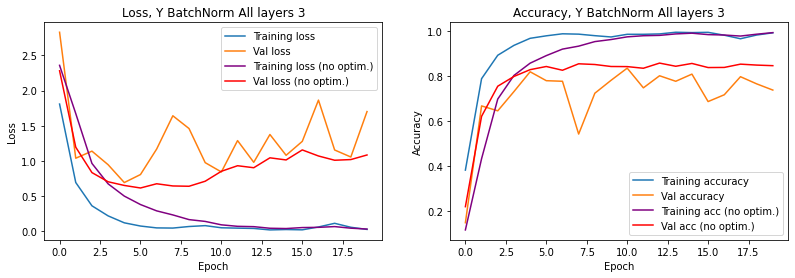

In [38]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyYbatchALL1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchALL1,'Y BatchNorm All layers '+str(i), historyYvgg4)
    elif i ==2:
        historyYbatchALL2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchALL2,'Y BatchNorm All layers '+str(i), historyYvgg4)   
    else:
        historyYbatchALL3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchALL3,'Y BatchNorm All layers '+str(i), historyYvgg4)
        
    i += 1

In [44]:
historyYbatchALL2.history['val_accuracy'][-1]

0.8979166746139526

In [45]:
historyYbatchALL2.history['val_loss'][-1]

0.6955239176750183

#### Learning rates

##### **0.001**

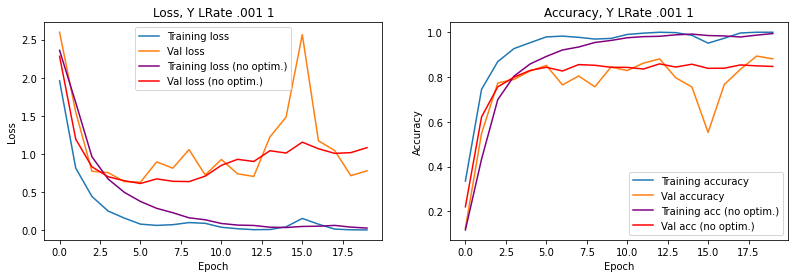

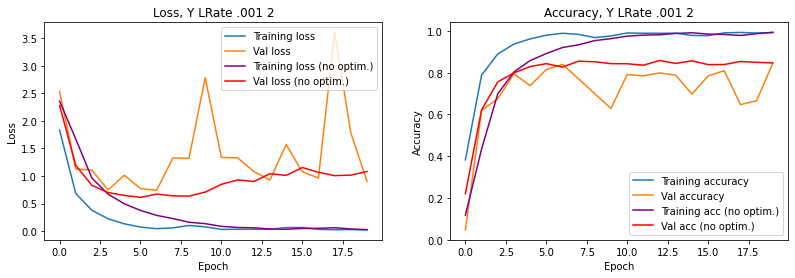

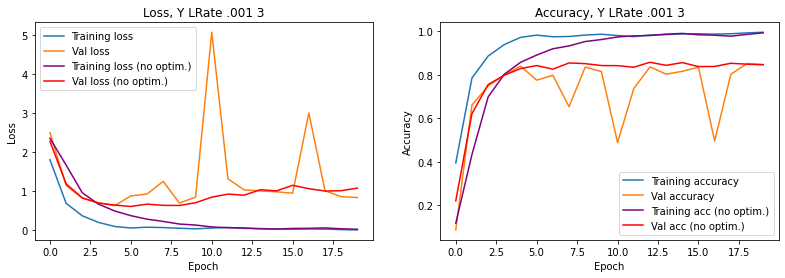

In [73]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyYlearning1_1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning1_1,'Y LRate .001 '+str(i), historyYvgg4)
    elif i ==2:
        historyYlearning1_2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning1_2,'Y LRate .001 '+str(i), historyYvgg4)   
    else:
        historyYlearning1_3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning1_3,'Y LRate .001 '+str(i), historyYvgg4)
        
    i += 1

In [95]:
historyYlearning1_1.history['val_accuracy'][-1]

0.8807291388511658

In [96]:
historyYlearning1_1.history['val_loss'][-1]

0.7788426876068115

##### **0.0008**

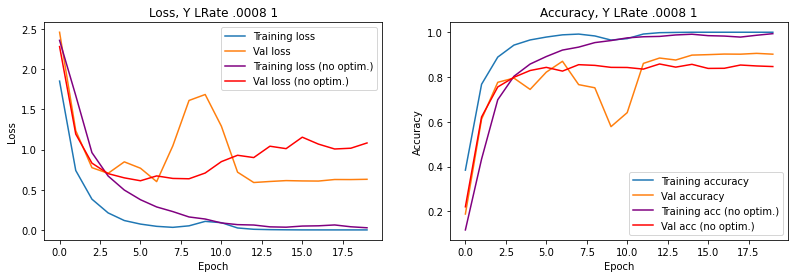

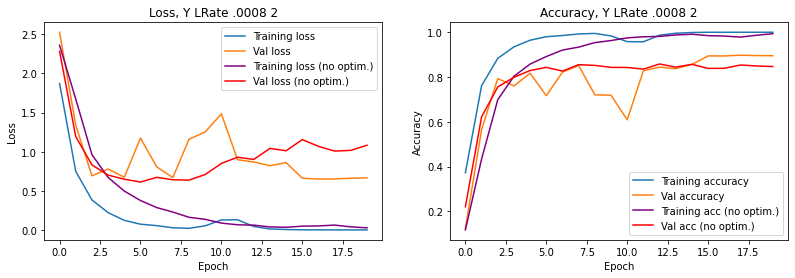

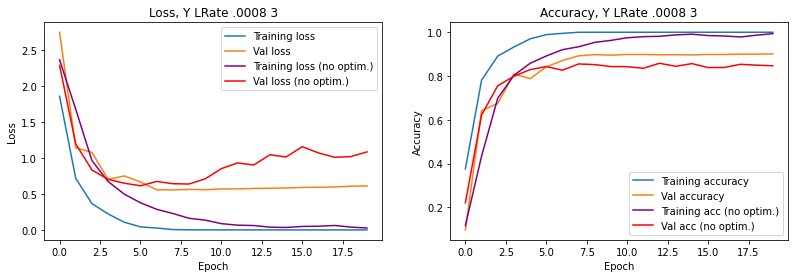

In [105]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyYlearning08_1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning08_1,'Y LRate .0008 '+str(i), historyYvgg4)
    elif i ==2:
        historyYlearning08_2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning08_2,'Y LRate .0008 '+str(i), historyYvgg4)   
    else:
        historyYlearning08_3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning08_3,'Y LRate .0008 '+str(i), historyYvgg4)
        
    i += 1

In [112]:
historyYlearning08_1.history['val_accuracy'][-1]

0.9020833373069763

In [113]:
historyYlearning08_1.history['val_loss'][-1]

0.6301223635673523

##### **0.0005**

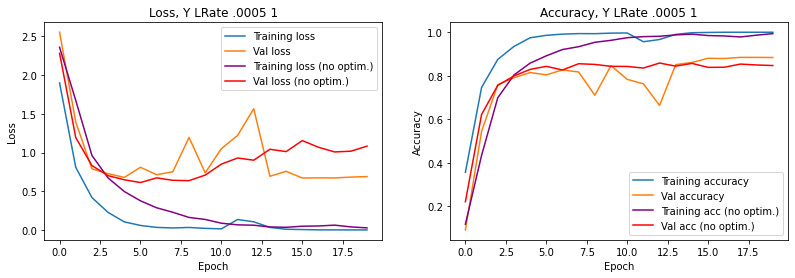

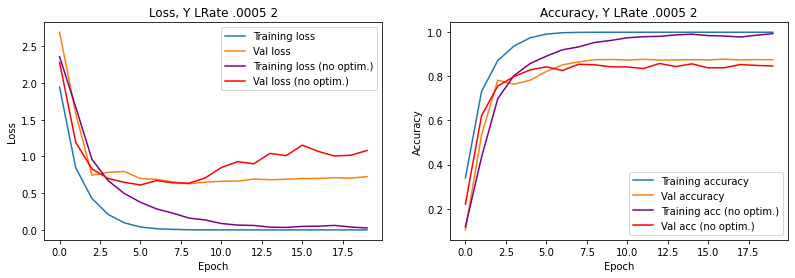

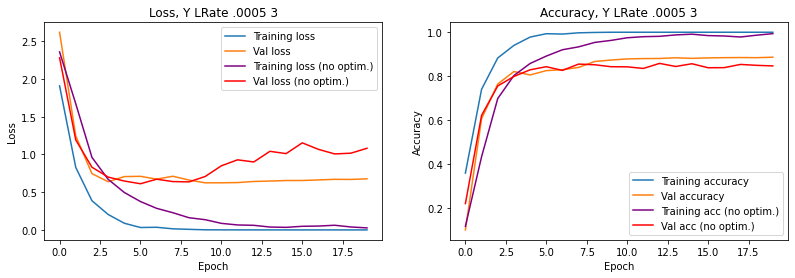

In [101]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyYlearning05_1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning05_1,'Y LRate .0005 '+str(i), historyYvgg4)
    elif i ==2:
        historyYlearning05_2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning05_2,'Y LRate .0005 '+str(i), historyYvgg4)   
    else:
        historyYlearning05_3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning05_3,'Y LRate .0005 '+str(i), historyYvgg4)
        
    i += 1

In [114]:
historyYlearning05_3.history['val_accuracy'][-1]

0.8864583373069763

In [115]:
historyYlearning05_3.history['val_loss'][-1]

0.6771371960639954

#### Dropout 0,5

##### **First 2 layers**

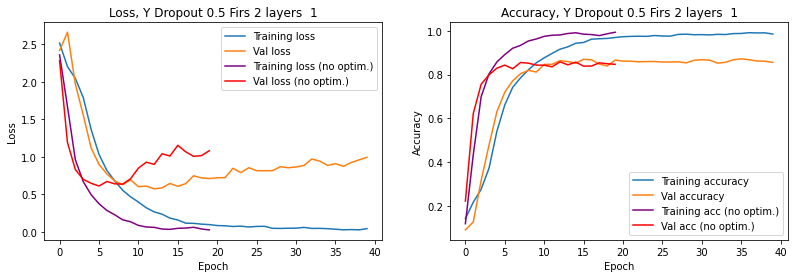

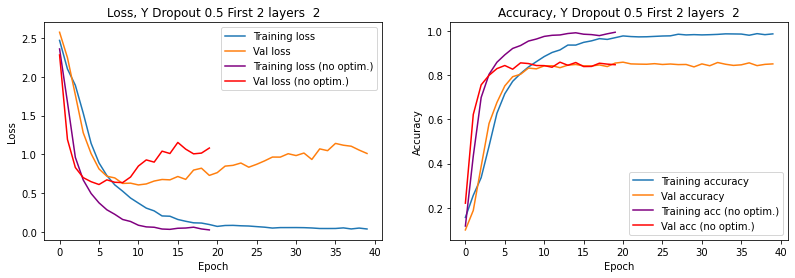

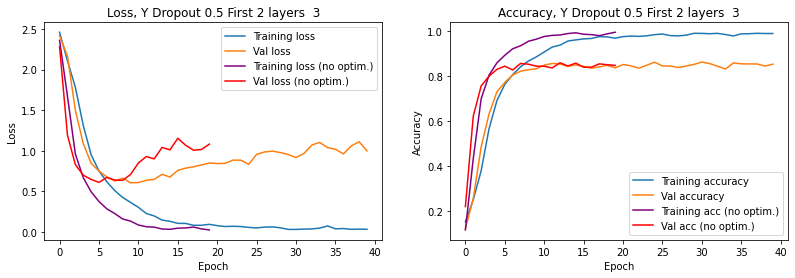

In [134]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYdropFIRST1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropFIRST1,'Y Dropout 0.5 Firs 2 layers  '+str(i), historyYvgg4)
    elif i ==2:
        historyYdropFIRST2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropFIRST2,'Y Dropout 0.5 First 2 layers  '+str(i), historyYvgg4)   
    else:
        historyYdropFIRST3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropFIRST3,'Y Dropout 0.5 First 2 layers  '+str(i), historyYvgg4)
        
    i += 1

In [155]:
historyYdropFIRST1.history['val_accuracy'][-1]

0.8557291626930237

In [156]:
historyYdropFIRST1.history['val_loss'][-1]

0.9938110113143921

##### **Last 2 layers**

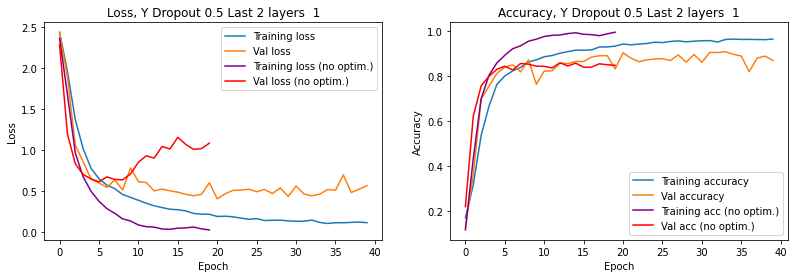

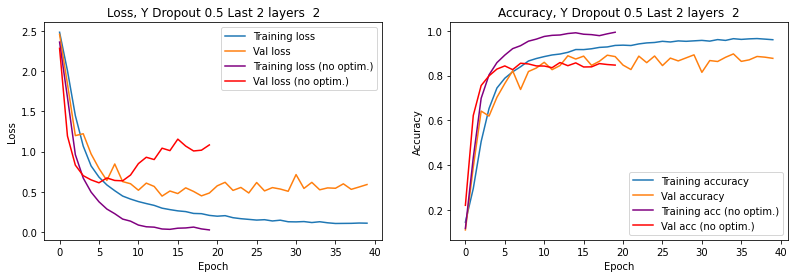

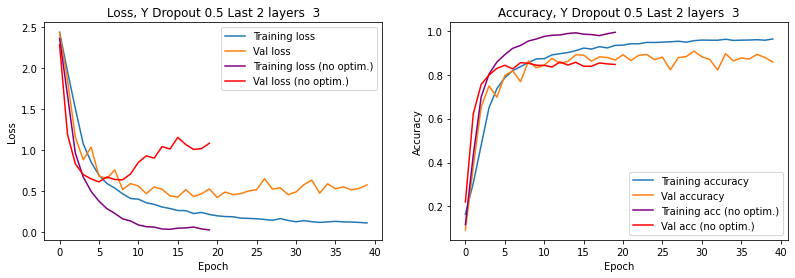

In [135]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYdropLAST1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropLAST1,'Y Dropout 0.5 Last 2 layers  '+str(i), historyYvgg4)
    elif i ==2:
        historyYdropLAST2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropLAST2,'Y Dropout 0.5 Last 2 layers  '+str(i), historyYvgg4)   
    else:
        historyYdropLAST3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropLAST3,'Y Dropout 0.5 Last 2 layers  '+str(i), historyYvgg4)
        
    i += 1

In [161]:
historyYdropLAST2.history['val_accuracy'][-1]

0.8770833611488342

In [162]:
historyYdropLAST2.history['val_loss'][-1]

0.5904884338378906

##### **All layers**

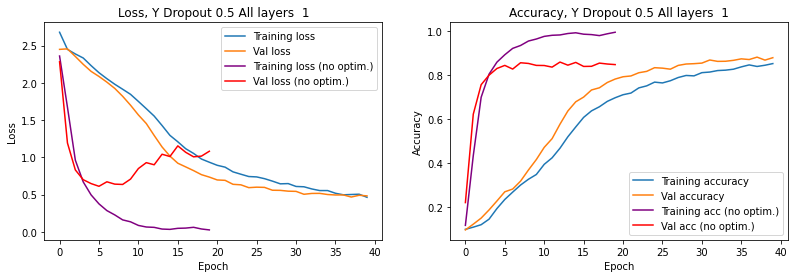

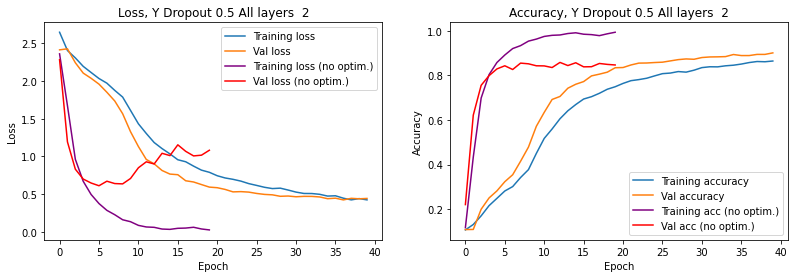

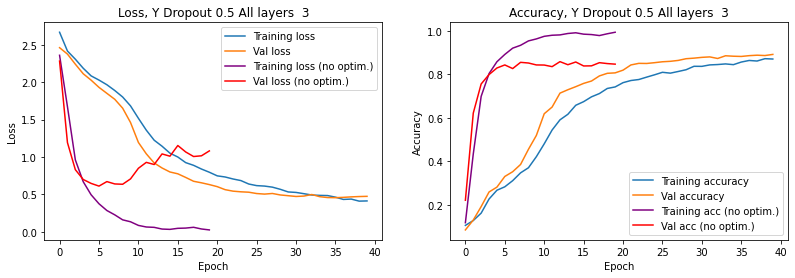

In [136]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYdropALL1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropALL1,'Y Dropout 0.5 All layers  '+str(i), historyYvgg4)
    elif i ==2:
        historyYdropALL2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropALL2,'Y Dropout 0.5 All layers  '+str(i), historyYvgg4)   
    else:
        historyYdropALL3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropALL3,'Y Dropout 0.5 All layers  '+str(i), historyYvgg4)
        
    i += 1

In [165]:
historyYdropALL2.history['val_accuracy'][-1]

0.9010416865348816

In [166]:
historyYdropALL2.history['val_loss'][-1]

0.44380703568458557

#### Earlystopping on optimized model

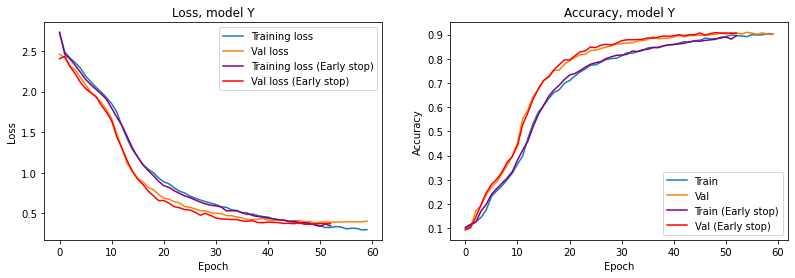

In [65]:
### with early stop
model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_stop = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=60, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

  
#### Without early stop

model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=60, verbose=0)

########
### Plot with and without early stop
########

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
ax.plot(history_stop.history['loss'], 'purple', label = 'Training loss (Early stop)')
ax.plot(history_stop.history['val_loss'], 'red', label = 'Val loss (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
ax.plot(history_stop.history['accuracy'], 'purple', label = 'Train (Early stop)')
ax.plot(history_stop.history['val_accuracy'], 'red', label = 'Val (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, model Y')

plt.show()


#### Performance on test data

Epoch 1/100
240/240 [==============================] - 2s 6ms/step - loss: 2.6711 - accuracy: 0.0967 - val_loss: 2.4805 - val_accuracy: 0.0927
Epoch 2/100
240/240 [==============================] - 1s 5ms/step - loss: 2.4252 - accuracy: 0.1095 - val_loss: 2.5314 - val_accuracy: 0.1099
Epoch 3/100
240/240 [==============================] - 1s 5ms/step - loss: 2.3346 - accuracy: 0.1465 - val_loss: 2.2978 - val_accuracy: 0.1823
Epoch 4/100
240/240 [==============================] - 1s 5ms/step - loss: 2.2526 - accuracy: 0.1818 - val_loss: 2.2173 - val_accuracy: 0.2438
Epoch 5/100
240/240 [==============================] - 1s 5ms/step - loss: 2.1670 - accuracy: 0.2219 - val_loss: 2.1185 - val_accuracy: 0.2740
Epoch 6/100
240/240 [==============================] - 1s 5ms/step - loss: 2.1029 - accuracy: 0.2499 - val_loss: 2.0730 - val_accuracy: 0.2948
Epoch 7/100
240/240 [==============================] - 1s 5ms/step - loss: 2.0240 - accuracy: 0.2790 - val_loss: 1.9969 - val_accuracy: 0.3359

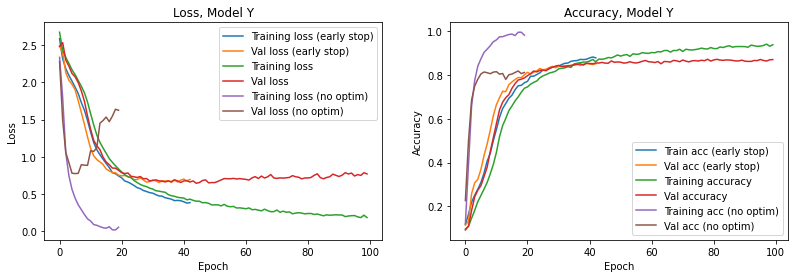

In [17]:
 ### with early stop
model_Y_stop = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_Y_stop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_Y_stop = model_Y_stop.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

 ### withOUT early stop
model_Y_no_stop = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_Y_no_stop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_Y_no_stop = model_Y_no_stop.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=100, verbose=1,)

##############################################################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_Y_stop.history['loss'], label='Training loss (early stop)')
ax.plot(history_Y_stop.history['val_loss'], label = 'Val loss (early stop)')
ax.plot(history_Y_no_stop.history['loss'], label='Training loss')
ax.plot(history_Y_no_stop.history['val_loss'], label = 'Val loss')
ax.plot(historyYvgg4.history['loss'], label='Training loss (no optim)')
ax.plot(historyYvgg4.history['val_loss'], label = 'Val loss (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_Y_stop.history['accuracy'], label='Train acc (early stop)')
ax.plot(history_Y_stop.history['val_accuracy'], label = 'Val acc (early stop)')
ax.plot(history_Y_no_stop.history['accuracy'], label='Training accuracy')
ax.plot(history_Y_no_stop.history['val_accuracy'],  label = 'Val accuracy')
ax.plot(historyYvgg4.history['accuracy'], label='Training acc (no optim)')
ax.plot(historyYvgg4.history['val_accuracy'], label = 'Val acc (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model Y')

plt.show()


In [18]:
history_Y_stop.history['val_accuracy'][-1]

0.8510416746139526

In [19]:
history_Y_stop.history['val_loss'][-1]

0.6966617703437805

In [20]:
history_Y_no_stop.history['val_accuracy'][-1]

0.870312511920929

In [21]:
historyYvgg4.history['val_accuracy'][-1]

0.8114583492279053

In [23]:
model_Y_stop.evaluate(x_test,Y_test)

75/75 [==============================] - 0s 2ms/step - loss: 0.4637 - accuracy: 0.8838


[0.46368885040283203, 0.8837500214576721]

In [22]:
#model_Y_stop.save('models/model_Y_optimized_earlystop.h5')

### **ModelD**

#### Previous model VGG4

In [51]:
modelY = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

modelY.compile(
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

historyDvgg4 = modelY.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)

In [52]:
historyDvgg4.history['val_accuracy'][-1]

0.9307291507720947

In [53]:
historyDvgg4.history['val_loss'][-1]

0.5557824969291687

#### Batch normalization

##### **-2 first layers**

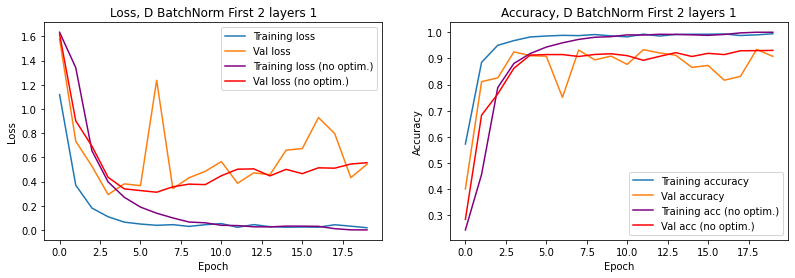

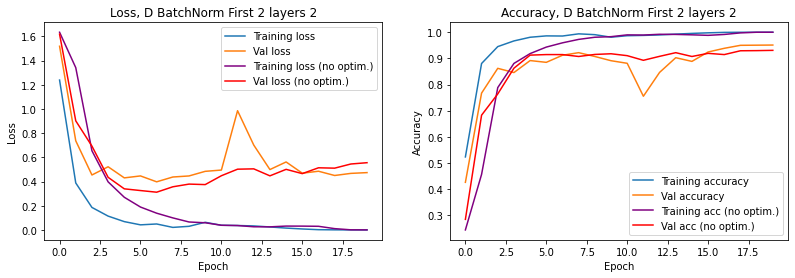

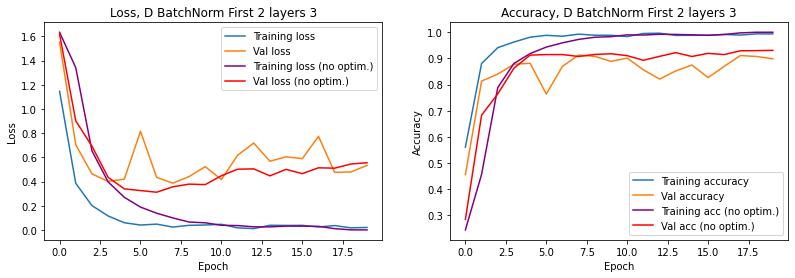

In [55]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDbatchFIRST1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchFIRST1,'D BatchNorm First 2 layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDbatchFIRST2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchFIRST2,'D BatchNorm First 2 layers '+str(i), historyDvgg4)   
    else:
        historyDbatchFIRST3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchFIRST3,'D BatchNorm First 2 layers '+str(i), historyDvgg4)
        
    i += 1

In [59]:
historyDbatchFIRST2.history['val_accuracy'][-1]

0.9510416388511658

In [60]:
historyDbatchFIRST2.history['val_loss'][-1]

0.47380027174949646

##### **-2 last layers**

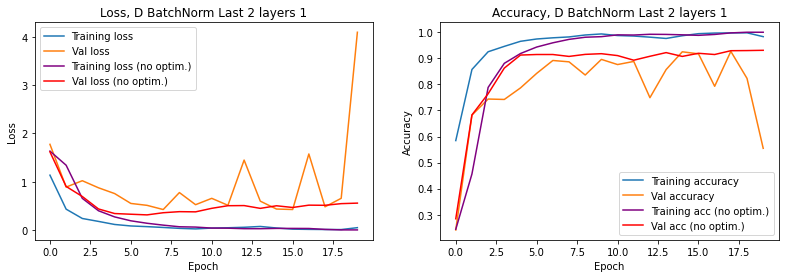

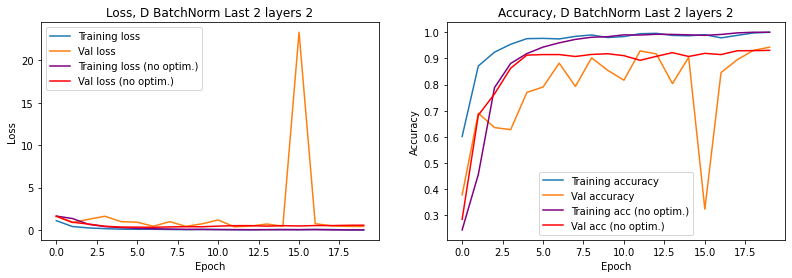

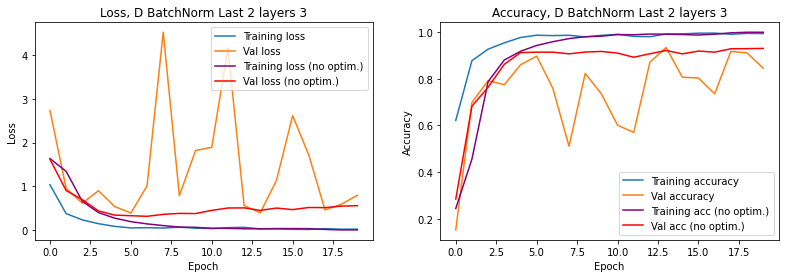

In [58]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDbatchLAST1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchLAST1,'D BatchNorm Last 2 layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDbatchLAST2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchLAST2,'D BatchNorm Last 2 layers '+str(i), historyDvgg4)   
    else:
        historyDbatchLAST3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchLAST3,'D BatchNorm Last 2 layers '+str(i), historyDvgg4)
        
    i += 1

In [63]:
historyDbatchLAST2.history['val_accuracy'][-1]

0.9427083134651184

In [64]:
historyDbatchLAST2.history['val_loss'][-1]

0.41255050897598267

##### **-all 4 layers**

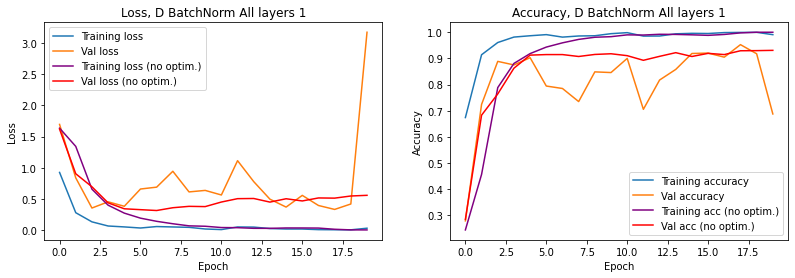

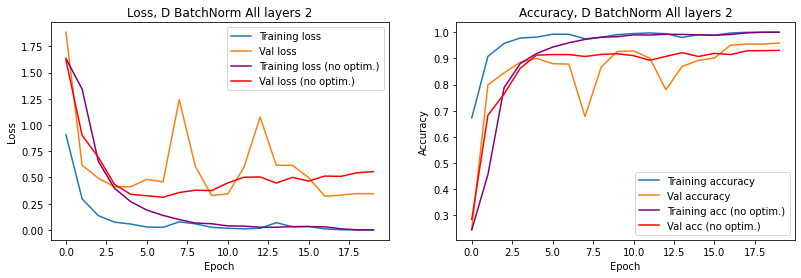

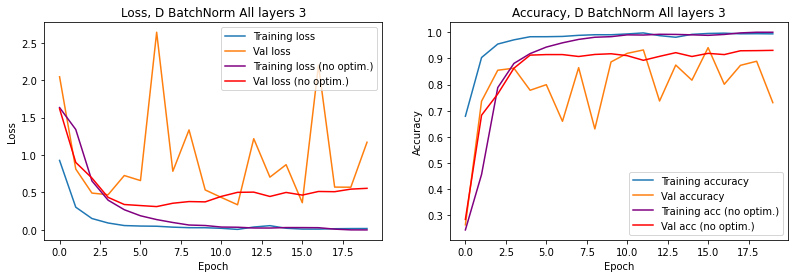

In [57]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyDbatchALL1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchALL1,'D BatchNorm All layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDbatchALL2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchALL2,'D BatchNorm All layers '+str(i), historyDvgg4)   
    else:
        historyDbatchALL3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchALL3,'D BatchNorm All layers '+str(i), historyDvgg4)
        
    i += 1

In [61]:
historyDbatchALL2.history['val_accuracy'][-1]

0.9588541388511658

In [62]:
historyDbatchALL2.history['val_loss'][-1]

0.3446910083293915

#### Learning rates

##### **0.001**

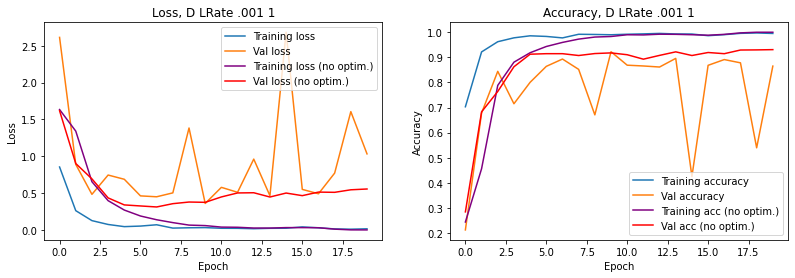

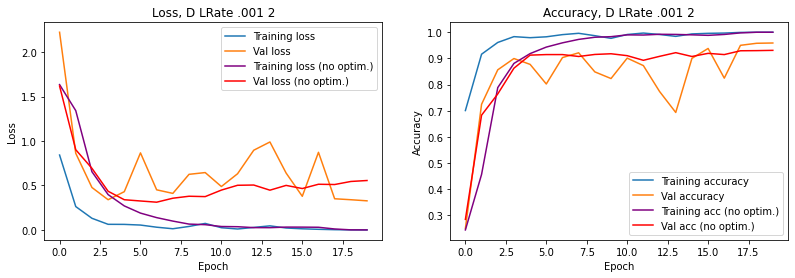

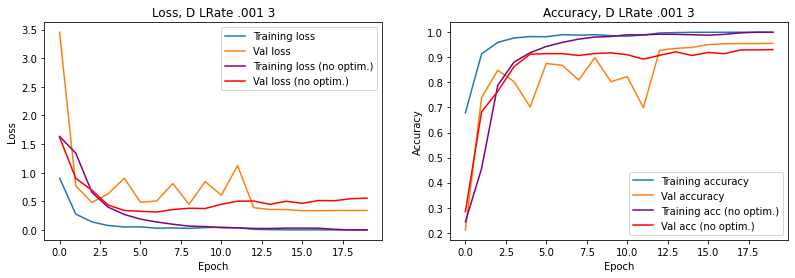

In [76]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyDlearning1_1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning1_1,'D LRate .001 '+str(i), historyDvgg4)
    elif i ==2:
        historyDlearning1_2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning1_2,'D LRate .001 '+str(i), historyDvgg4)   
    else:
        historyDlearning1_3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning1_3,'D LRate .001 '+str(i), historyDvgg4)
        
    i += 1

In [116]:
historyDlearning1_2.history['val_accuracy'][-1]

0.9588541388511658

In [117]:
historyDlearning1_2.history['val_loss'][-1]

0.32726046442985535

##### **0.0008**

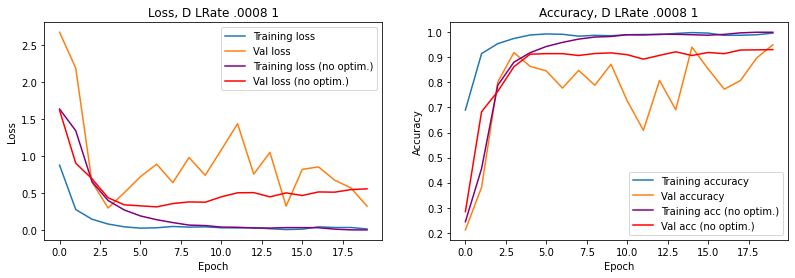

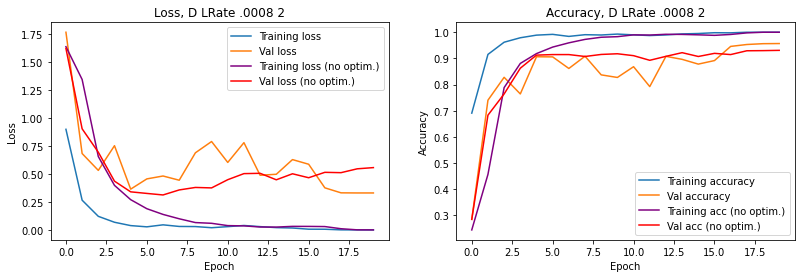

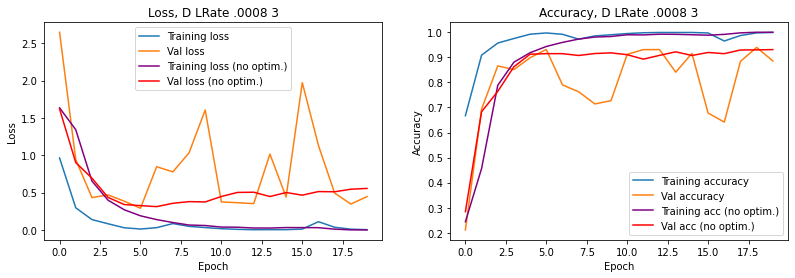

In [77]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyDlearning08_1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning08_1,'D LRate .0008 '+str(i), historyDvgg4)
    elif i ==2:
        historyDlearning08_2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning08_2,'D LRate .0008 '+str(i), historyDvgg4)   
    else:
        historyDlearning08_3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning08_3,'D LRate .0008 '+str(i), historyDvgg4)
        
    i += 1

In [118]:
historyDlearning08_2.history['val_accuracy'][-1]

0.9567708373069763

In [119]:
historyDlearning08_2.history['val_loss'][-1]

0.32973718643188477

##### **0.0005**

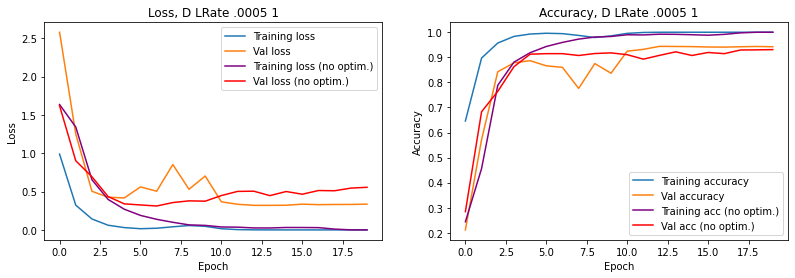

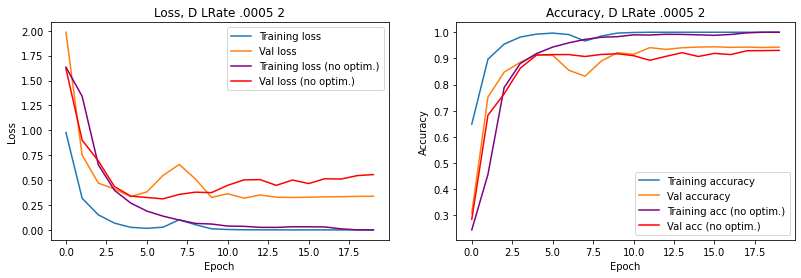

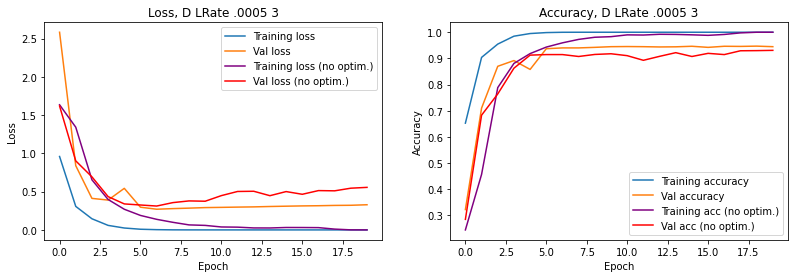

In [123]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyDlearning05_1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning05_1,'D LRate .0005 '+str(i), historyDvgg4)
    elif i ==2:
        historyDlearning05_2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning05_2,'D LRate .0005 '+str(i), historyDvgg4)   
    else:
        historyDlearning05_3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning05_3,'D LRate .0005 '+str(i), historyDvgg4)
        
    i += 1

In [128]:
historyDlearning05_3.history['val_accuracy'][-1]

0.9447916746139526

In [130]:
historyDlearning05_3.history['val_loss'][-1]

0.32879817485809326

#### Dropout 0,5

##### **First 2 layers**

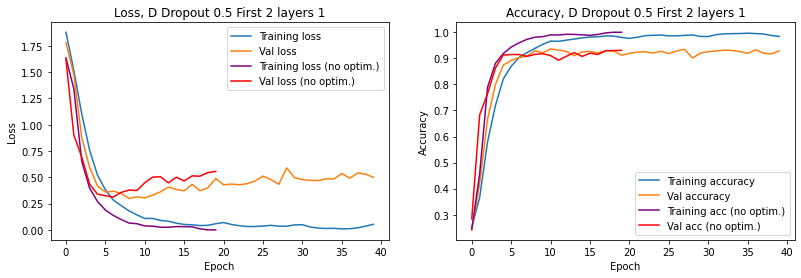

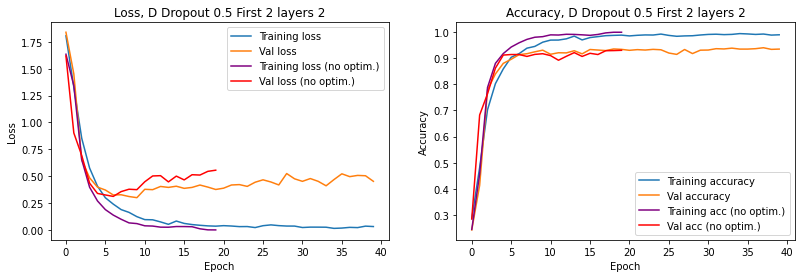

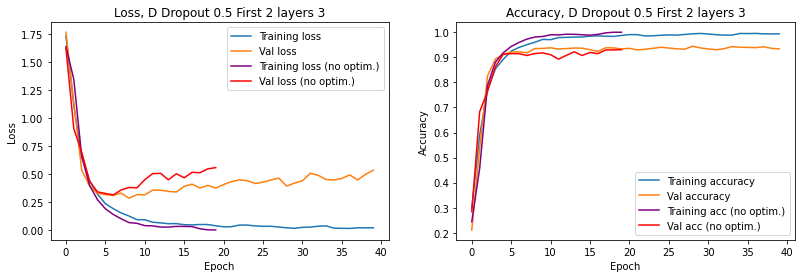

In [137]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDdropFIRST1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropFIRST1,'D Dropout 0.5 First 2 layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDdropFIRST2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropFIRST2,'D Dropout 0.5 First 2 layers '+str(i), historyDvgg4)   
    else:
        historyDdropFIRST3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropFIRST3,'D Dropout 0.5 First 2 layers '+str(i), historyDvgg4)
        
    i += 1

In [169]:
historyDdropFIRST2.history['val_accuracy'][-1]

0.9354166388511658

In [170]:
historyDdropFIRST2.history['val_loss'][-1]

0.4522238075733185

##### **Last 2 layers**

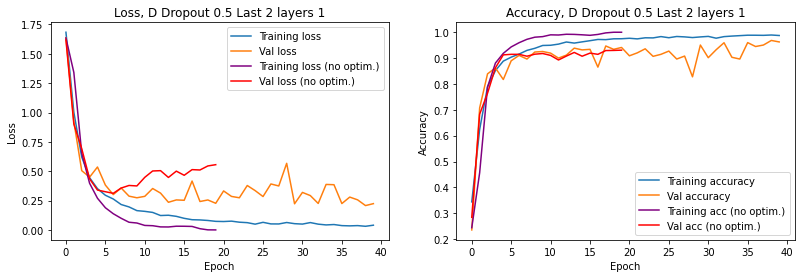

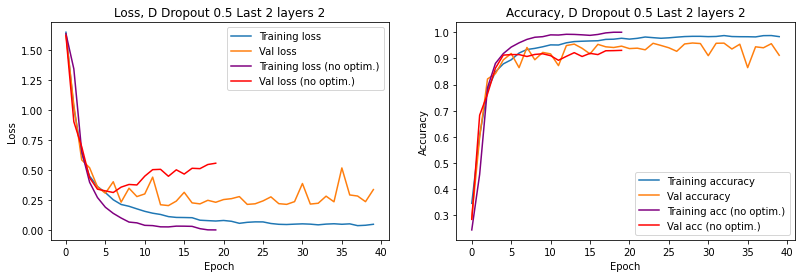

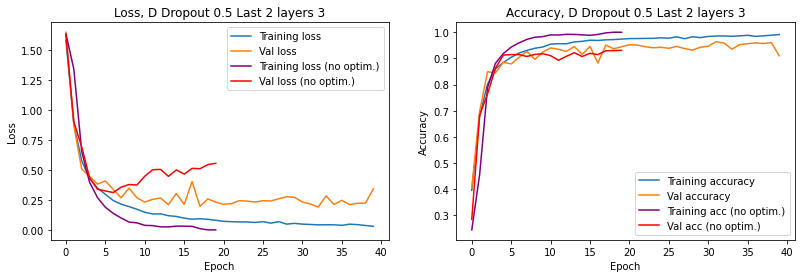

In [138]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDdropLAST1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropLAST1,'D Dropout 0.5 Last 2 layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDdropLAST2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropLAST2,'D Dropout 0.5 Last 2 layers '+str(i), historyDvgg4)   
    else:
        historyDdropLAST3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropLAST3,'D Dropout 0.5 Last 2 layers '+str(i), historyDvgg4)
        
    i += 1

In [171]:
historyDdropLAST1.history['val_accuracy'][-1]

0.9624999761581421

In [172]:
historyDdropLAST1.history['val_loss'][-1]

0.22397831082344055

##### **All layers**

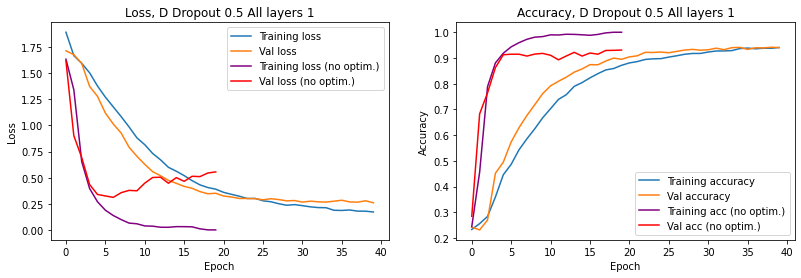

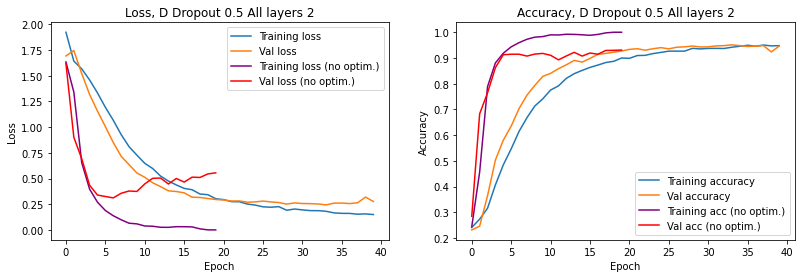

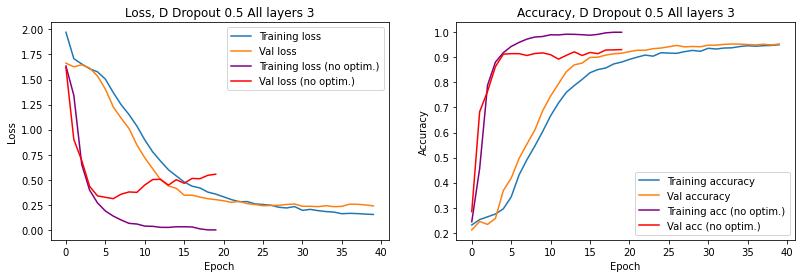

In [139]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDdropALL1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropALL1,'D Dropout 0.5 All layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDdropALL2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropALL2,'D Dropout 0.5 All layers '+str(i), historyDvgg4)   
    else:
        historyDdropALL3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropALL3,'D Dropout 0.5 All layers '+str(i), historyDvgg4)
        
    i += 1

In [175]:
historyDdropALL3.history['val_accuracy'][-1]

0.953125

In [176]:
historyDdropALL3.history['val_loss'][-1]

0.2404295802116394

#### Earlystopping on optimized model

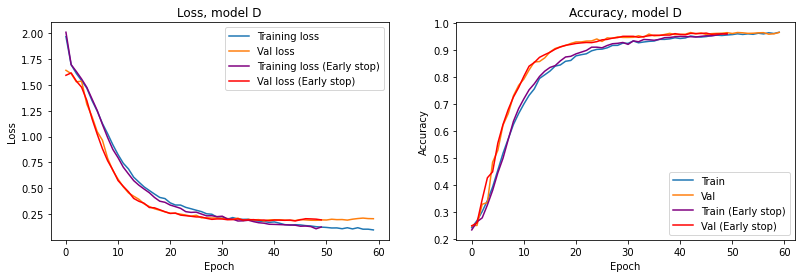

In [60]:
### with early stop
model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_stop = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=60, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

  
#### Without early stop

model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=60, verbose=0)

########
### Plot with and without early stop
########

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
ax.plot(history_stop.history['loss'], 'purple', label = 'Training loss (Early stop)')
ax.plot(history_stop.history['val_loss'], 'red', label = 'Val loss (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
ax.plot(history_stop.history['accuracy'], 'purple', label = 'Train (Early stop)')
ax.plot(history_stop.history['val_accuracy'], 'red', label = 'Val (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, model D')

plt.show()


#### Performance on test data

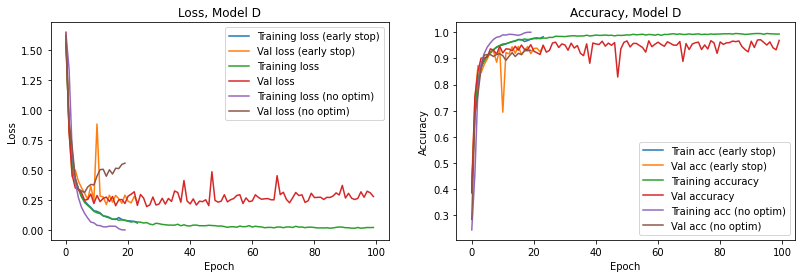

In [225]:
 ### with early stop
model_D_stop = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_D_stop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_D_stop = model_D_stop.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

 ### withOUT early stop
model_D_no_stop = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_D_no_stop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_D_no_stop = model_D_no_stop.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=100, verbose=0,)

##############################################################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_D_stop.history['loss'], label='Training loss (early stop)')
ax.plot(history_D_stop.history['val_loss'], label = 'Val loss (early stop)')
ax.plot(history_D_no_stop.history['loss'], label='Training loss')
ax.plot(history_D_no_stop.history['val_loss'], label = 'Val loss')
ax.plot(historyDvgg4.history['loss'], label='Training loss (no optim)')
ax.plot(historyDvgg4.history['val_loss'], label = 'Val loss (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_D_stop.history['accuracy'], label='Train acc (early stop)')
ax.plot(history_D_stop.history['val_accuracy'], label = 'Val acc (early stop)')
ax.plot(history_D_no_stop.history['accuracy'], label='Training accuracy')
ax.plot(history_D_no_stop.history['val_accuracy'],  label = 'Val accuracy')
ax.plot(historyDvgg4.history['accuracy'], label='Training acc (no optim)')
ax.plot(historyDvgg4.history['val_accuracy'], label = 'Val acc (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()

In [226]:
history_D_stop.history['val_accuracy'][-1]

0.9479166865348816

In [227]:
history_D_stop.history['val_loss'][-1]

0.23252330720424652

In [228]:
history_D_no_stop.history['val_accuracy'][-1]

0.96875

In [229]:
historyDvgg4.history['val_accuracy'][-1]

0.9307291507720947

In [236]:
model_D_stop.save('models/model_D_optimized_earlystop.h5')